# IMDB data

In [1]:
import keras
import time
from nltk.corpus import stopwords
import nltk
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatajadd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
NUM_WORDS=10000 # only use top 1000 words
INDEX_FROM=3   # word index offset

train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS,
                                           index_from=INDEX_FROM,
                                           skip_top=0,
                                           maxlen=None,
                                           start_char=1,
                                           oov_char=2
                                          )
train_x,train_y = train
test_x,test_y = test

# build id_to_word and word_to_id while removing stop words
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items() if k not in STOP_WORDS}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
#word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
# remove stop words from train and test
train_x = [[wordid for wordid in review if wordid in id_to_word] for review in train_x]
test_x = [[wordid for wordid in review if wordid in id_to_word] for review in test_x]
#print(' '.join(id_to_word[id] for id in train_x[3] ))

# Contextual Word Embedding
In this section, 
    we explain the idea behaid word embedding,
    visualize it in 3D to make it easier to understand,
    

# Training FastText with Gensim
Explain the advantage of FastText over W2V, use Gensim to train a custom FastText model

In [6]:
# We need an streamer ...
from gensim.models.fasttext import FastText as FT_gensim
class Streamer(object):
    def __init__(self, file):
        self.file = file
    def __iter__(self):
        for line in self.file:
            yield [id_to_word[item] for item in line]

In [7]:
n = 0
for i in Streamer(train_x):
    if n< 2:
        print(len(i))
        n +=1 
    else:
        break
    

96
100


In [8]:
embedding_size = 100
model_FT = FT_gensim(size=embedding_size, window=5, sg = 1, negative =5,
                  #ns_exponent=0.6,
                min_count=0,
                 sorted_vocab = 1,
                 min_n = 2,
                 max_n = 7,
                word_ngrams = 1,#?????????????????????????
                  workers  = 8,
                 )
model_FT.build_vocab(sentences=Streamer(train_x))
total_examples = model_FT.corpus_count
total_words = model_FT.corpus_total_words
print("{} total words in the doc, {} used words from {} total sentences".format(
        total_words,
        len(model_FT.wv.vocab),
        total_examples))

3184795 total words in the doc, 9842 used words from 25000 total sentences


In [9]:
# run the training or load the trained model from disk.
Load_from_disk = False
rootpath = "trained_models/"
model_file_name = "model_FT_from_scratch.model"
os.makedirs(rootpath, exist_ok = True)
if not Load_from_disk:
    st = time.time()
    model_FT.train(sentences=Streamer(train_x), total_examples=total_examples, epochs=5)
    ed = time.time()
    print("train took {} minutes".format((ed-st)/60))
    model_FT.save(rootpath + model_file_name)
else:
    model_FT = FT_gensim.load(rootpath + model_file_name)

train took 4.00930392742157 minutes


C:\Users\fatajadd\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [11]:
# how to get word vector:
model_FT.wv["marrage"]

array([-0.03513087,  0.12188011, -0.04018265,  0.07391978, -0.03339139,
        0.21236858,  0.30384234, -0.14488263, -0.12549329, -0.00090982,
        0.36993426, -0.13426004, -0.19717784, -0.1858572 ,  0.12253143,
        0.08524233,  0.274842  , -0.12234534, -0.23821881, -0.06410537,
       -0.5444922 ,  0.05789662,  0.06875348, -0.19430697,  0.13115643,
        0.07390526,  0.35660657, -0.10753442,  0.15129086,  0.20190012,
        0.40881228,  0.17467022, -0.00319589,  0.221459  , -0.1308901 ,
       -0.02046585, -0.20395352,  0.12667686, -0.13333146, -0.13475232,
        0.01599183,  0.47232243, -0.12457272,  0.05260322, -0.02071696,
       -0.3366263 ,  0.02933438, -0.0033564 , -0.01146686, -0.00564239,
        0.23217824,  0.16319391,  0.12731571,  0.17476499, -0.11789199,
       -0.03706553, -0.0408514 ,  0.119171  , -0.29841432, -0.14371271,
       -0.13770282,  0.0619759 ,  0.28681207,  0.16067193, -0.11641547,
       -0.01891778,  0.07726547,  0.17383093, -0.07910086, -0.15

In [13]:
word1 = "good"
word2 = "vnice"
for word in [word1,word2]:
    if word in model_FT.wv.vocab:
        print("{} \t\t exists".format(word))
    else:
        print("{} \t\t does NOT exist".format(word))
sim = model_FT.wv.similarity(word1, word2)
print("{} and {} are {:.3}% similar".format(word1, word2, sim*100))

good 		 exists
vnice 		 does NOT exist
good and vnice are 56.1% similar


In [18]:
# get top N words most similar to a quesry word
quyery_word = "menace"
similar_words_count = 10
similar_words = model_FT.wv.similar_by_word(quyery_word,similar_words_count)
similar_words

[('menacing', 0.7919787764549255),
 ('villainous', 0.7048004865646362),
 ('villain', 0.6819924116134644),
 ('villains', 0.6526587009429932),
 ('demonic', 0.6460725665092468),
 ('warrior', 0.6374690532684326),
 ('henchmen', 0.6341953277587891),
 ('antagonist', 0.6311025023460388),
 ('frenzy', 0.6310278177261353),
 ('foreboding', 0.630985677242279)]

# Visualize Trained models
Use a results from the above code trained offline to visualize
Query models for a few words and show similarity
use T-SNE to plot clusters of Words

C:\Users\fatajadd\AppData\Local\Continuum\anaconda3\envs\MLADS\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


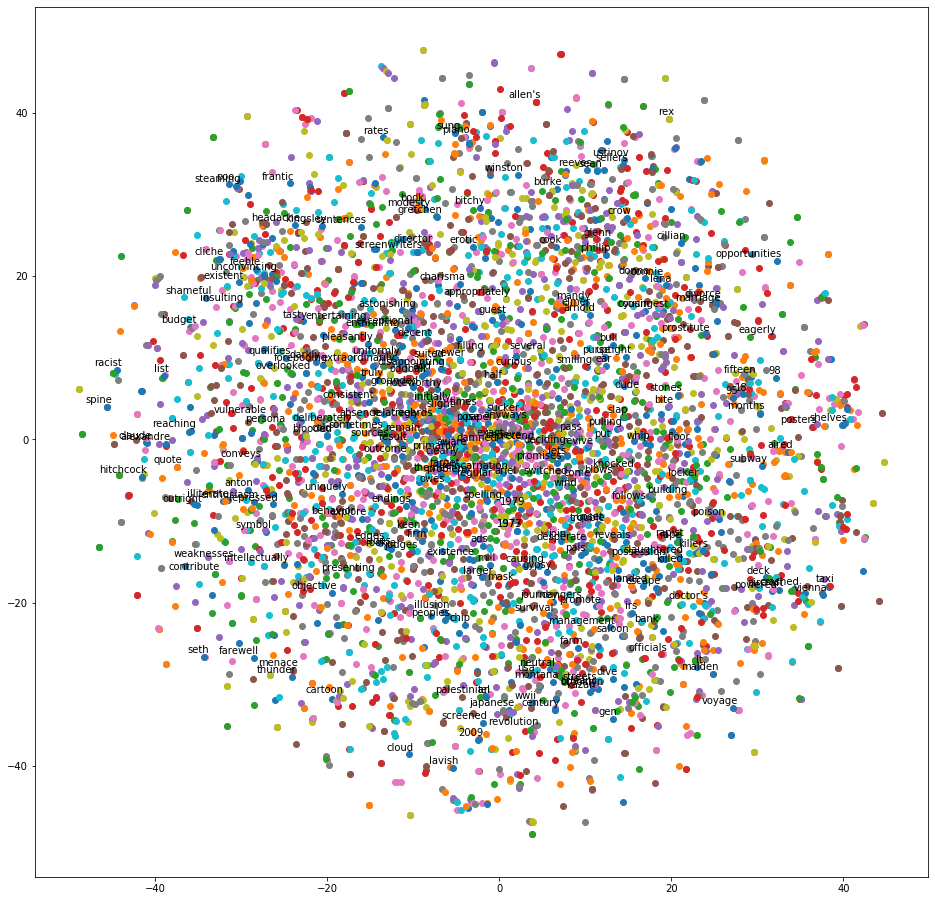

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from random import sample
def tsne_plot(model):
    """Creates and TSNE model and plots it"""
    labels = []
    tokens = []
    
    vocab =[x for x in model_FT.wv.vocab]
    index_to_plot = sample(range(0,len(vocab)),5000)
    for wordid in index_to_plot:
        tokens.append(model[vocab[wordid]])
        labels.append(vocab[wordid])
        
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        if i%20==0:
            plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model_FT)

# Use Word Embeddings for Classification
Take the best model from the previous step, use FastText and W2V features instead of the original feature.
Also download wordwmbeddings trained on a large public corpus to do the sa

In [19]:
# Build input matrices
import numpy as np
def build_inputs_with_embedding(x,
                                embedding_model = model_FT, 
                                id_to_word=id_to_word,
                                max_review_len = 200,
                                mode="as-is"):
    """
    takes the original reviews, and builds a 2D matrix of samples*features ready to be used for ML
    Based on the mode, features can be:
        mode = "as-is": each word in the review is replaced by its embedding vector. 
        mode = "agg_on_sentence": aggreagate all words in a review to get only one vector per sentence
        
    """
    embedding_size = len(model_FT.wv["sample"])
    if mode=="as-is":
        x_with_embedding = np.zeros((len(x), max_review_len,embedding_size))
        for i in range(len(x)):
            tmp = 3 * np.ones(max_review_len)
            for j in range(max_review_len):
                if j<len(x[i]):
                    tmp[j] = x[i][j]
                x_with_embedding[i,j,:] = embedding_model.wv[id_to_word[tmp[j]]]
        x_with_embedding = x_with_embedding.reshape((len(x),max_review_len*embedding_size))
        return x_with_embedding
    elif mode=="agg_on_sentence":
        x_with_embedding = np.zeros((len(x), embedding_size))
        for i in range(len(x)):
            x_with_embedding[i,:] = np.sum([embedding_model.wv[id_to_word[j]] for j in x[i] if j<max_review_len], axis=0)
        return x_with_embedding
train_x_with_embedding = build_inputs_with_embedding(train_x, mode = "agg_on_sentence")
print("train set size to use :", train_x_with_embedding.shape)
test_x_with_embedding = build_inputs_with_embedding(test_x, mode = "agg_on_sentence")
print("test set size to use :", test_x_with_embedding.shape)

train set size to use : (25000, 100)
test set size to use : (25000, 100)


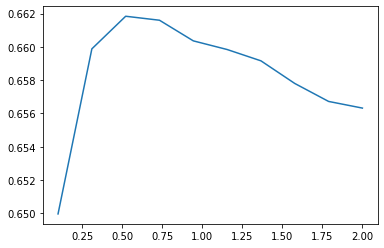

In [19]:
#SVC model
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
C_to_tune = np.linspace(0.1,2,10)
CV_scores = []
folds = 3
for c in C_to_tune:
    svc = SVC(C = c, gamma='auto')
    svc.fit(train_x_with_embedding, train_y) 
    CV_scores.append(sum(cross_val_score(svc, train_x_with_embedding, train_y, cv=folds))/folds) 
plt.plot(C_to_tune,CV_scores)

In [43]:
svc = SVC(C = 0.5, gamma='auto')
svc.fit(train_x_with_embedding, train_y) 
accuracy_train = svc.score(train_x_with_embedding,train_y)
print("accuracy on train set = {:.3f}%".format(accuracy_train*100))
accuracy_test = svc.score(test_x_with_embedding,test_y)
print("accuracy on test set = {:.3f}%".format(accuracy_test*100))

accuracy on train set = 81.068%
accuracy on test set = 70.960%


In [41]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0)
RF.fit(train_x_with_embedding, train_y) 
accuracy_train = RF.score(train_x_with_embedding,train_y)
print("accuracy on train set = {:.3f}%".format(accuracy_train*100))
accuracy_test = svc.score(test_x_with_embedding,test_y)
print("accuracy on test set = {:.3f}%".format(accuracy_test*100))

accuracy on train set = 73.912%
accuracy on test set = 67.160%


In [30]:
from sklearn.metrics import roc_curve, auc
probs = RF.predict_proba(test_x_with_embedding)
def plot_roc(True_Labels, Probablities, modelname):
    fpr, tpr, thresholds = roc_curve(True_Labels, Probablities)
    roc_auc = auc(fpr,tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
    ax.set_title("ROC curve for " + modelname)
    ax.legend(loc="lower right")
    #ax.set_xscale('log')
    #plt.show()
    #return fig

plot_roc(test_y,np.max(probs, axis=1),"SVM")